In [1]:
%matplotlib widget
import numpy as np
import json, os, glob, numbers
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *

import warnings
warnings.filterwarnings('ignore')

<a id='averaged_XAS'></a>
## Load data

In [2]:
pgroup = 'p22588'
Loaddir_name = ''

runlist = [195]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Test/{}/'.format(pgroup, Loaddir_name)

In [3]:
# Plot_correlations_scan(pgroup, Loaddir, run=runlist[0], path='raw', timescan=False, lowlim = 0.95)
# Plot_scan_2diodes(pgroup, Loaddir, run=runlist[0],  threshold=0, path='raw', timescan=False)

In [4]:
Loaddir = '/sf/alvra/data/{}/work/Test/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]

from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)

data1, titlestring_stack1 = load_reduced_data(pgroup, Loaddir, runlist, switch_diodes=False)
#Plot_reduced_data(data1, scan, titlestring_stack1)
data2, titlestring_stack2 = load_reduced_data(pgroup, Loaddir, runlist, switch_diodes=True)
#Plot_reduced_data(data2, scan, titlestring_stack2)

readbacks = np.asarray(data1['readbacks'], dtype=object)

20 21 21
3274 shots out of 5156 survived


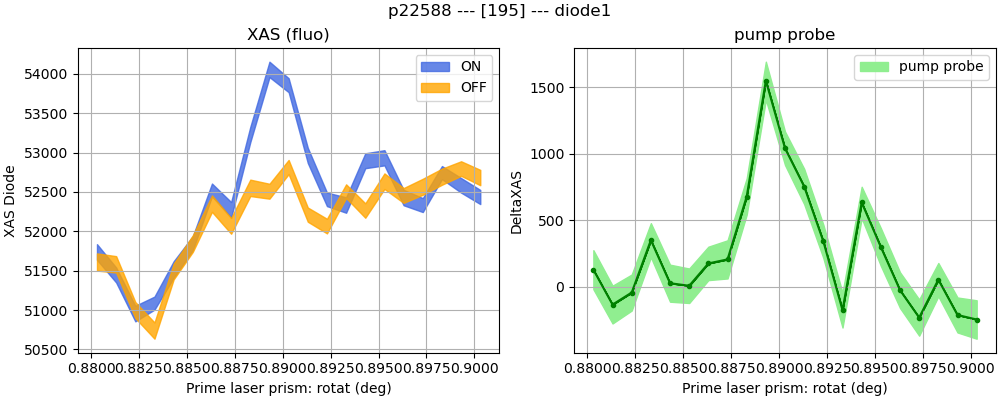

Data saved in /sf/alvra/data/p22588/work/Test//_singlerun/run195/
20 21 21
3283 shots out of 5156 survived


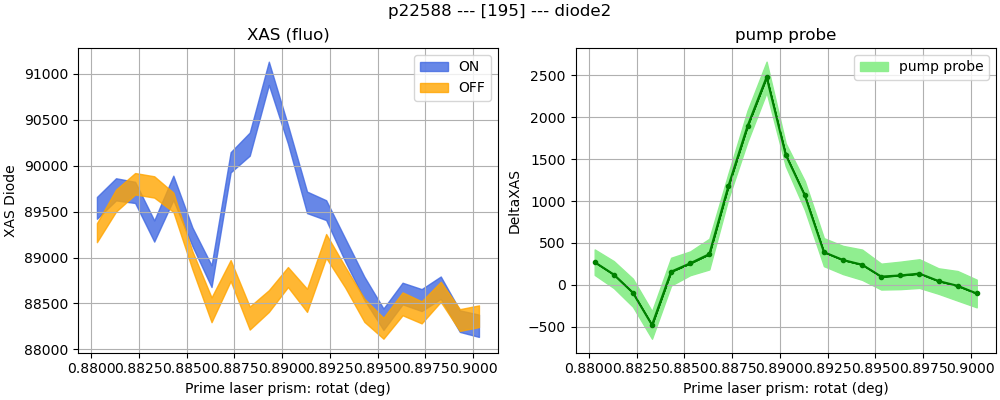

Data saved in /sf/alvra/data/p22588/work/Test//_singlerun/run195/


In [5]:
quantile1 = 0.8
quantile2 = 0.8

##############################################
rbk = np.array(readbacks[0], dtype=float)
indexNans = np.ones(len(rbk), dtype=bool)
           
results1 = Rebin_and_filter_energyscans_PP(data1, quantile1, rbk, threshold=0, n_sigma=5, raw=True)
plot_filtered_data(results1, scan, rbk, titlestring_stack1)
save_averaged_data(Loaddir, runlist, results1, rbk, "diode1", indexNans)

results2 = Rebin_and_filter_energyscans_PP(data2, quantile2, rbk, threshold=0, n_sigma=5, raw=True)
plot_filtered_data(results2, scan, rbk, titlestring_stack2)
save_averaged_data(Loaddir, runlist, results2, rbk, "diode2", indexNans)

Data saved in /sf/alvra/data/p22588/work/Test//_singlerun/run195/


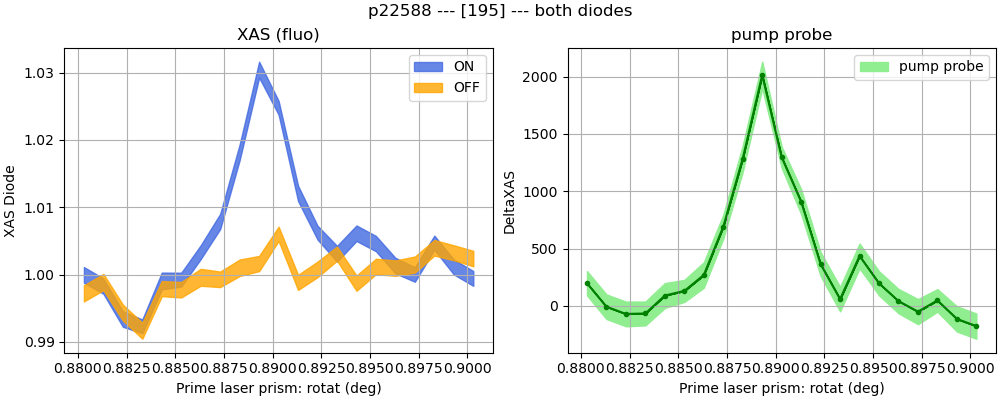

In [6]:
results1_norm = normalize_spectra (results1)
results2_norm = normalize_spectra (results2)

results_ave, titlestring_ave = average_two_diodes(results1_norm, results2_norm, titlestring_stack1)
save_averaged_data(Loaddir, runlist, results2, rbk, "both_diodes", indexNans)
plot_filtered_data(results_ave, scan, rbk, titlestring_ave)

## Fluence scan

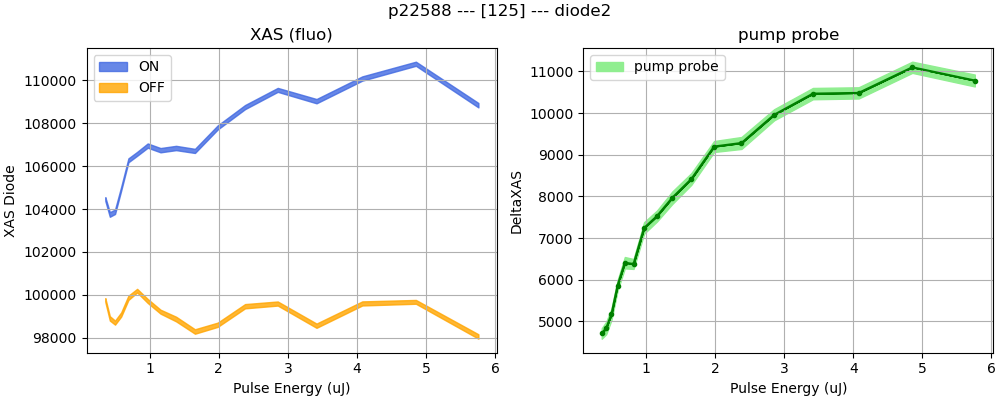

In [14]:
params = [8.884032634033035e-08, -4.7302965552968094e-05, 0.00972551379176431, -0.9228802318052738, 34.45745687645803]  # 470 nm
params = [5.900349650349897e-08, -3.483119658119821e-05, 0.007863167249417576, -0.8133037101787356, 33.00922843822912]  # 600 nm

p = np.poly1d(params)
intensity = p(rbk)                                                         ## pulse energy (in uJ)
scan.parameters['name'][0] = 'Pulse Energy'
scan.parameters['units'][0] = 'uJ'

plot_filtered_data(results2, scan, intensity, titlestring_stack2)

## Overlay data

In [21]:
pgroup = 'p22588'

runlist2load = [125, 126]

Loaddir_folder = '_singlerun' #_single #_multiruns
whichdiode = 'diode2'  #both_diodes
# whichdiode = 'diode1'  #both_diodes

whichaverage = [0,0]
##############################################
Loaddir = '/sf/alvra/data/{}/work/Test/{}/'.format(pgroup, Loaddir_folder)

titlestring_stack = pgroup + ' --- ' +str(runlist2load)
print ('Will load {} runs: {} from {}'.format(len(runlist2load), runlist2load, Loaddir))
check = []
for i, (run, avg) in enumerate(zip(runlist2load, whichaverage)):
    try:
        check.append(glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run, whichdiode))[avg])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [125, 126] from /sf/alvra/data/p22588/work/Test/_singlerun/


['/sf/alvra/data/p22588/work/Test/_singlerun/run125/run_array_diode2.npy',
 '/sf/alvra/data/p22588/work/Test/_singlerun/run126/run_array_diode2.npy']

0
0


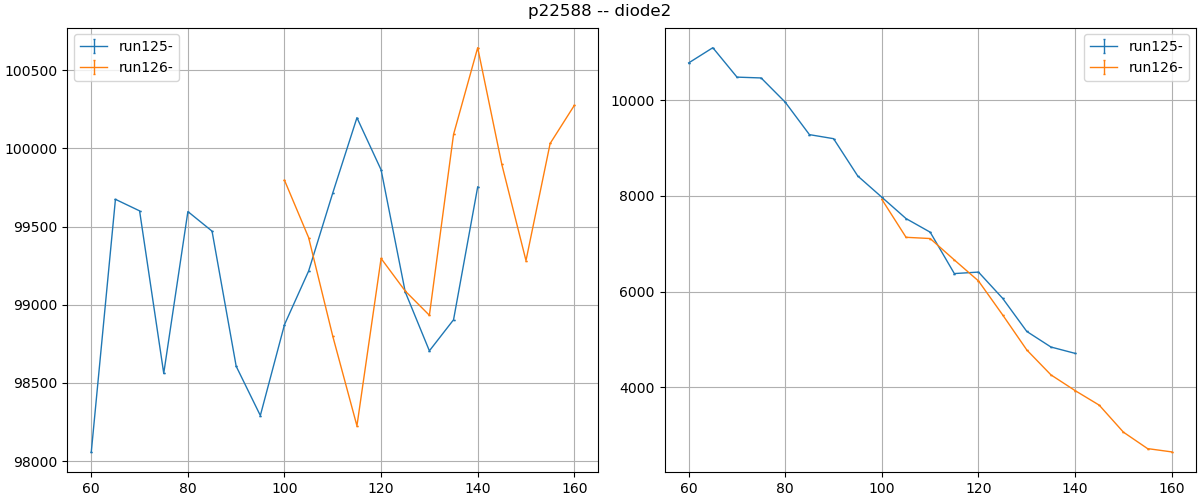

In [22]:
fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
if whichdiode=='diode1':
    switchdiode=False
else:
    switchdiode=True
    
peak = []
lab=['','']
scale = [1,1]*len(runlist2load)

for index, (run, avg) in enumerate(zip(runlist2load, whichaverage)):
    print (avg)
    
    filepath = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run, whichdiode))[avg]
    # print(filepath)
    run_array = np.load(filepath, allow_pickle=True).item()
    for key in run_array.keys():
        runname  = run_array[key]["name"].split('-')[0]
        GS       = run_array[key]["GS"]
        err_GS   = run_array[key]["err_GS"]
        
        ES       = run_array[key]["ES"]
        err_ES   = run_array[key]["err_ES"]
        pp_rebin = run_array[key]["pp"]
        err_pp   = run_array[key]["err_pp"]
        rbk      = run_array[key]["readbacks"]
    # print(index)
    peak.append(max(GS)-np.mean(GS[:5]))
    ax1.errorbar(rbk, GS, 0, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname+'-'+str(lab[index]))
    ax3.errorbar(rbk, pp_rebin*scale[index], 0, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname+'-'+str(lab[index]))
    
plt.suptitle('{} -- {}'.format(pgroup, whichdiode))
ax1.legend(loc = 'upper left')
ax1.grid()
ax3.legend(loc = 'upper right')
ax3.grid()

In [197]:
ttime = []
ff = []
for run in runlist2load:
    f = glob.glob('/sf/alvra/data/p22588/raw/*{:04d}*/meta/scan.json'.format(run))[0]
    print (f)
    ff.append(f)
    #ttime.append(timestamp_hms(f))
    ttime.append(creation_date(f))

/sf/alvra/data/p22588/raw/run0021-PtLQ_XANES_1ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0024-PtLQ_XANES_1ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0028-PtLQ_XANES_100fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0029-PtLQ_XANES_100fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0030-PtLQ_XANES_500fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0033-PtLQ_XANES_1ps_1uJ_001/meta/scan.json
/sf/alvra/data/p22588/raw/run0034-PtLQ_XANES_1ps_1uJ_002/meta/scan.json
/sf/alvra/data/p22588/raw/run0052-PtLQ_XANES_200fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0053-PtLQ_XANES_350fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0055-PtLQ_XANES_5ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0058-PtLQ_XANES_10ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0059-PtLQ_XANES_10ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0060-PtLQ_XANES_10ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0061-PtLQ_XANES_20ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/

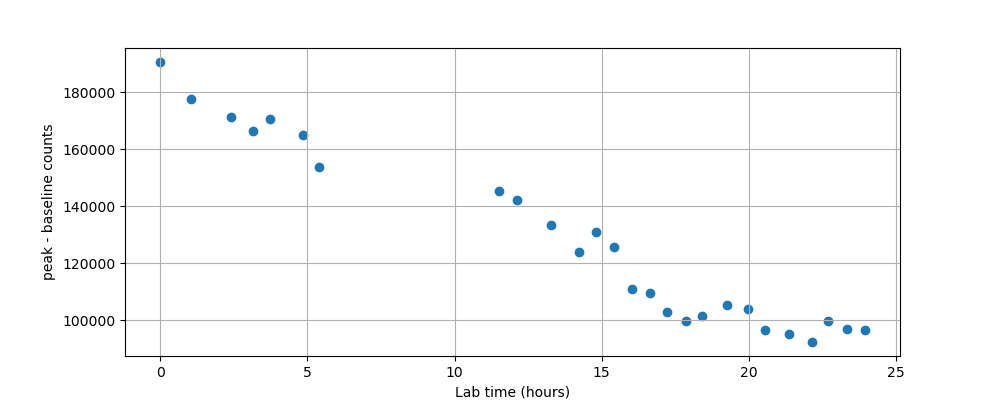

In [198]:
plt.figure(figsize=(10,4))
plt.scatter((np.array(ttime)-np.array(ttime)[0])/3600, peak)
#plt.scatter(ttime, peak)
#plt.gcf().autofmt_xdate()


plt.ylabel('peak - baseline counts')
plt.xlabel('Lab time (hours)')
plt.grid()
plt.show()

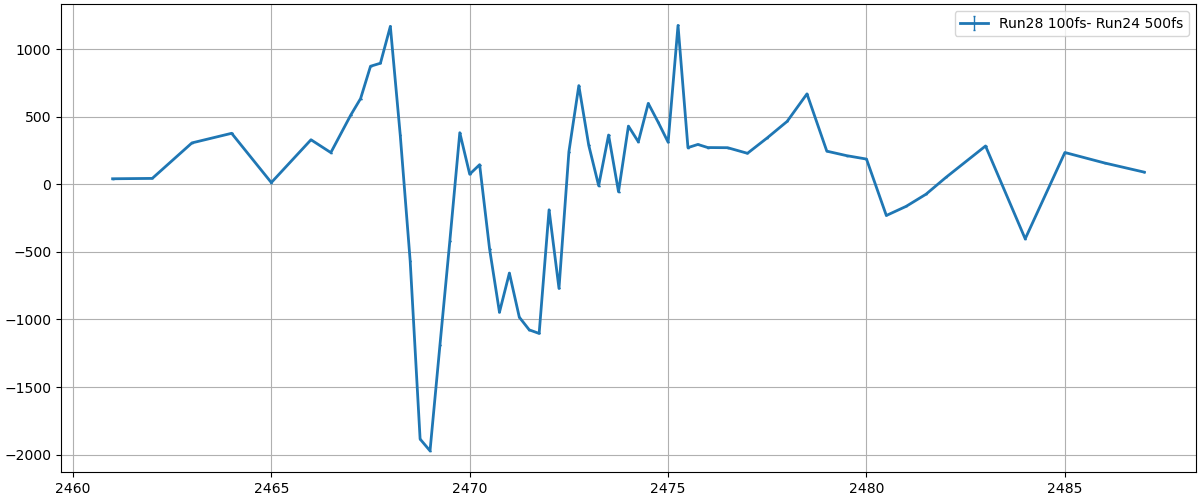

In [15]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)
if whichdiode=='diode1':
    switchdiode=False
else:
    switchdiode=True

run1 = 28
run2 = 24

label1 = '100fs'
label2 = '500fs'

filepath1 = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run1, whichdiode))[0]
filepath2 = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run2, whichdiode))[0]
run_array1 = np.load(filepath1, allow_pickle=True).item()
run_array2 = np.load(filepath2, allow_pickle=True).item()

for key in run_array1.keys():
        
        runname  = run_array1[key]["name"].split('-')[0]
        GS       = run_array1[key]["GS"]
        err_GS   = run_array1[key]["err_GS"]
        ES       = run_array1[key]["ES"]
        err_ES   = run_array1[key]["err_ES"]
        pp_rebin1 = run_array1[key]["pp"]
        err_pp   = run_array1[key]["err_pp"]
        rbk1     = run_array1[key]["readbacks"]

for key in run_array2.keys():
        runname  = run_array2[key]["name"].split('-')[0]
        GS       = run_array2[key]["GS"]
        err_GS   = run_array2[key]["err_GS"]
        ES       = run_array2[key]["ES"]
        err_ES   = run_array2[key]["err_ES"]
        pp_rebin2 = run_array2[key]["pp"]
        err_pp   = run_array2[key]["err_pp"]
        rbk2     = run_array2[key]["readbacks"]

# plt.show()

# plt.show()
# plt.suptitle('{} -- {}'.format(pgroup, whichdiode))
# ax1.legend(loc = 'upper left')
# ax1.grid()
# ax3.legend(loc = 'upper left')
# ax3.grid()



ax1.errorbar(rbk1, pp_rebin1-pp_rebin2, 0, lw=2,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label = 'Run'+str(run1)+' '+label1 +'- Run'+str(run2)+' '+label2)
ax1.legend()
plt.grid()
plt.show()